In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy

%load_ext tensorboard
import datetime

# Translated image generation

In [318]:
x_size = 50
y_size = 50
test_img = tf.keras.utils.load_img('test_drawing_2.png', color_mode="grayscale", target_size=(x_size, y_size))
test_img = tf.keras.utils.load_img('box.png', color_mode="grayscale", target_size=(x_size, y_size))
#test_img = tf.keras.utils.load_img('photo1.png', color_mode="grayscale", target_size=(x_size, y_size))
test_img_arr = tf.keras.utils.img_to_array(test_img) / 255.0
test_img_arr = 1.0 - test_img_arr

In [319]:
def img_to_vecs(img):
    output = np.zeros((x_size * y_size, 2))
    rescaled_img = 2.0 * img.flatten() - 1.0
    output[:, 0] = np.sin(rescaled_img * np.pi / 2.0)
    output[:, 1] = np.cos(rescaled_img * np.pi / 2.0)
    return output

def vecs_to_img(vecs):
    v = vecs.reshape((x_size, y_size, 2))
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    img = np.arcsin(v[:, :, 0:1]) / np.pi * 2.0
    img = (1.0 + img) / 2.0
    img = 255.0 * np.clip(img, 0.0, 1.0)
    return img

In [339]:
m = 1024
px_count = x_size * y_size
X = np.zeros((m, 2, px_count, 2))
X_t2 = np.zeros((m, 2, px_count, 2))
X_t4 = np.zeros((m, 2, px_count, 2))
for i in range(m):
    img_1 = tf.keras.preprocessing.image.random_shift(test_img_arr, 0.3, 0.3, row_axis=0, col_axis=1, channel_axis=2)
    img_1 = tf.keras.preprocessing.image.random_rotation(img_1, 90, row_axis=0, col_axis=1, channel_axis=2)
    img_2 = tf.keras.preprocessing.image.random_rotation(img_1, 30, row_axis=0, col_axis=1, channel_axis=2)
    
    #img_1 = tf.keras.preprocessing.image.random_shift(test_img_arr, 0.5, 0.5, row_axis=0, col_axis=1, channel_axis=2)
    #img_2 = tf.keras.preprocessing.image.random_shift(img_1, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2)
    #mg_3 = tf.keras.preprocessing.image.random_shift(img_1, 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2)
    #mg_4 = tf.keras.preprocessing.image.random_shift(img_1, 0.4, 0.4, row_axis=0, col_axis=1, channel_axis=2)
    X[i][0] = img_to_vecs(img_1)
    X[i][1] = img_to_vecs(img_2)
    #_t2[i][0] = img_to_vecs(img_1)
    #_t2[i][1] = img_to_vecs(img_3)
    #_t4[i][0] = img_to_vecs(img_1)
    #_t4[i][1] = img_to_vecs(img_4)
Y = X

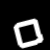

In [340]:
img = vecs_to_img(X[1][0])
tf.keras.utils.array_to_img(img, scale=False)

# Alternative: MNIST DS

In [969]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Sort by label:
sorted_indexes = np.argsort(Y_train, axis=0)
X_train_sorted = np.take_along_axis(X_train, np.expand_dims(sorted_indexes, (1,2)), axis=0)

In [970]:
m = X_train.shape[0]
m = int(m/2)
x_size = X_train.shape[1]
y_size = X_train.shape[2]
px_count = x_size * y_size
X = np.zeros((m, 2, px_count, 2))
for i in range(0, m):
    # Pair up images with the same labels (most of the time, can be off by one)
    img_1 = X_train_sorted[2*i] / 255.0
    img_2 = X_train_sorted[2*i+1] / 255.0
    X[i][0] = img_to_vecs(img_1)
    X[i][1] = img_to_vecs(img_2)

In [994]:
img = vecs_to_img(X[10000][0])
tf.keras.utils.array_to_img(img, scale=False)

# Layer architecture

In [972]:
def stable_norm(t, axis, keepdims=False):
    return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(t), axis=axis, keepdims=keepdims), tf.keras.backend.epsilon()))

def l1_norm(t, axis, keepdims=False):
    return tf.reduce_sum(tf.abs(t), axis=axis, keepdims=keepdims)

### Locality and context layers

In [973]:
class ContextAggregationLayer(tf.keras.layers.Layer):
    def __init__(self, context_fan_in, position_dim, num_samples, initial_sharpness, train_context, dtype=None):
        super(ContextAggregationLayer, self).__init__(dtype=dtype)

        self.context_fan_in = context_fan_in
        self.position_dim = position_dim
        self.num_samples = num_samples
        self.initial_sharpness = initial_sharpness
        self.train_context = train_context
    
    def build(self, input_shape):
        self.downstream_dim = input_shape[-1]
        self.downstream_num = input_shape[-2]

        # Encodes the positions of downstream columns
        # Positions are within a unit ball.
        self.downstream_positions = self.add_weight(
            shape=(self.downstream_num, self.position_dim),
            initializer=self.initialize_positions,
            name='downstream_positions',
            trainable=True,
            use_resource=True,
            constraint=tf.keras.constraints.MaxNorm(max_value=1, axis=1),
        )
        
        # These rotations form the "neighborhood" of a given position.    
        # Shape: position_dim -> position_dim * context_fan_in
        self.context_queries = Dense(
            self.position_dim * self.context_fan_in,
            use_bias=False,
            kernel_initializer=self.initialize_rotations,
            name='context_queries',
            trainable=self.train_context,
            kernel_constraint=self.constrain_to_rotations,
        )
        
        self.context_sharpness = self.add_weight(
            shape=(self.context_fan_in),
            initializer=tf.keras.initializers.Constant(value=self.initial_sharpness),
            name='context_sharpness',
            trainable=True,
            use_resource=True,
        )

        super(ContextAggregationLayer, self).build(input_shape)
    
    def initialize_positions(self, shape, dtype):
        rn = tf.keras.initializers.RandomNormal()(shape, dtype=dtype)
        # Initializing to smaller values initially helps positions converge faster.
        return 0.1 * tf.keras.constraints.UnitNorm(axis=1)(rn)
    
    def constrain_to_rotations(self, a):
        rs = tf.split(a, self.context_fan_in, axis=1)
        constrained_rs = []
        for r in rs:
            s, u, v = tf.linalg.svd(r)
            vh = tf.linalg.adjoint(v)
            constrained_rs.append(tf.matmul(u, vh))
            
        return tf.concat(constrained_rs, axis=1)
    
    def initialize_rotations(self, shape, dtype):
        identity = tf.keras.initializers.Identity()((self.position_dim, self.position_dim), dtype=dtype)
        rotations = []
        # The first rotation is always the identity (i.e. the seed value itself)
        rotations.append(identity)
        for i in range(1, self.context_fan_in):
            rotation = tf.keras.initializers.Orthogonal(gain=0.1)((self.position_dim, self.position_dim), dtype=dtype)
            rotations.append(identity + rotation)
        rotations = tf.concat(rotations, axis=1)
        return self.constrain_to_rotations(rotations)
    
    def sample_seed_indexes(self):
        # This tensorflow sampling method is inspired by https://stackoverflow.com/a/54755281
        # It approximates Numpy's np.random.choice with replace=False
        # Sampling different seed indexes for each batch helps the positions and contexts
        # to converge better to true neighborhoods. I was previously using a fixed sampling
        # throughout the whole training, and it led to the seed positions to get stuck
        # in specific values that didn't resemble their neighbors.

        uniform_distribution = tf.random.uniform([self.downstream_num], minval=0.0, maxval=1.0)
        _, top_indexes = tf.nn.top_k(uniform_distribution, self.num_samples)

        return top_indexes
    
    def reconstruct(self, full_context):        
        # Position shape: (..., num_columns, position_dim)
        # Value shape: (..., num_columns, context_fan_in * downstream_dim)
        position, values = tf.split(
            full_context,
            [
                self.position_dim,
                self.context_fan_in * self.downstream_dim,
            ],
            axis=-1,
        )
        
        # Restore normalization
        values *= np.sqrt(self.context_fan_in)

        # Shape: (context_fan_in, ..., num_columns, downstream_dim)
        values = tf.stack(tf.split(values, self.context_fan_in, axis=-1), axis=0)

        # Shape: (..., num_columns, context_fan_in * position_dim)
        queries = self.context_queries(position)
        
        # Shape: (context_fan_in, ..., num_columns, position_dim)
        queries = tf.stack(tf.split(queries, self.context_fan_in, axis=-1), axis=0)
        
        # Shape: (context_fan_in)
        exp_sharpness = tf.exp(self.context_sharpness)
        
        # Needed so we can call reconstruct directly when in mixed precision
        cast_downstream_positions = tf.cast(self.downstream_positions, self.compute_dtype)
        exp_sharpness = tf.cast(exp_sharpness, self.compute_dtype)
        queries = tf.cast(queries, self.compute_dtype)
        values = tf.cast(values, self.compute_dtype)
        
        # Process heads in sequence to reduce memory footprint
        reconstruction_shape = tf.concat([tf.shape(full_context)[0:-2], [self.downstream_num, self.downstream_dim]], axis=0)
        reconstruction = tf.zeros(reconstruction_shape, dtype=full_context.dtype)
        for head_idx in tf.range(0, self.context_fan_in):
            # Shape: (..., num_columns, position_dim)
            head_query = queries[head_idx]
            # Shape: (..., num_columns, downstream_dim)
            head_values = values[head_idx]
            # Shape: (1)
            head_sharpness = exp_sharpness[head_idx]
            # Shape: (..., num_samples, downstream_dim)
            head_output = self.compute_reconstruction_head_output(
                cast_downstream_positions,
                head_values,
                head_query,
                head_sharpness,
            )
            reconstruction = reconstruction + tf.cast(head_output, full_context.dtype)

        return reconstruction
    
    def call(self, downstream_input):
        # Shape: (num_samples, position_dim)
        seed_positions = tf.gather(self.downstream_positions, self.sample_seed_indexes(), axis=-2)
        
        # Shape: (num_samples, context_fan_in * position_dim)
        queries = self.context_queries(seed_positions)
        
        # Shape: (context_fan_in, num_samples, position_dim)
        queries = tf.stack(tf.split(queries, self.context_fan_in, axis=-1), axis=0)
        
        # Shape: (context_fan_in)
        exp_sharpness = tf.exp(self.context_sharpness)
        
        # Cast for mixed precision
        queries = tf.cast(queries, self.compute_dtype)
        exp_sharpness = tf.cast(exp_sharpness, self.compute_dtype)
        
        # Process heads in sequence to reduce memory footprint
        head_buffer = tf.TensorArray(dtype=self.compute_dtype, size=self.context_fan_in, clear_after_read=True)
        for head_idx in tf.range(0, self.context_fan_in):
            # Shape: (..., num_samples, position_dim)
            head_query = queries[head_idx]
            # Shape: (1)
            head_sharpness = exp_sharpness[head_idx]
            # Shape: (..., num_samples, downstream_dim)
            head_output = self.compute_attention_head_output(self.downstream_positions, downstream_input, head_query, head_sharpness)
            head_buffer = head_buffer.write(head_idx, head_output)

        # Restore normalization
        head_values = head_buffer.stack() / np.sqrt(self.context_fan_in)
        head_values = tf.unstack(head_values)
        
        # Shape: (..., num_samples, position_dim + context_fan_in * downstream_dim)
        expanded_seed_positions = tf.broadcast_to(
            seed_positions,
            tf.concat([tf.shape(head_values[0])[0:-1], [self.position_dim]], axis=0),
        )
        full_context = tf.concat([expanded_seed_positions] + head_values, axis=-1)

        return full_context
    
    @staticmethod
    @tf.function(jit_compile=True)
    #@tf.recompute_grad
    def compute_attention_head_output(downstream_positions, downstream_input, query, sharpness):
        # Shape: (downstream_num, position_dim), (num_samples, position_dim) -> (num_samples, downstream_num)
        attention_similarities = sharpness * tf.einsum('ND,SD->SN', downstream_positions, query)

        # Shape: (num_samples, downstream_num) -> (num_samples, downstream_num)
        attention_scores = tf.nn.softmax(attention_similarities, axis=-1)
        
        # Shape: (..., downstream_num, downstream_dim), (num_samples, downstream_num) -> (..., num_samples, downstream_dim)
        head_output = tf.einsum('...ND,SN->...SD', downstream_input, attention_scores)
        
        return head_output
    
    @staticmethod
    @tf.function(jit_compile=True)
    @tf.recompute_grad
    def compute_reconstruction_head_output(downstream_positions, values, query, sharpness):
        # Shape: (downstream_num, position_dim), (..., num_columns, position_dim) -> (..., num_columns, downstream_num)
        attention_similarities = sharpness * tf.einsum('ND,...SD->...SN', downstream_positions, query)
        
        # Shape: (..., num_columns, downstream_num) -> (..., num_columns, downstream_num)
        attention_scores = tf.nn.softmax(attention_similarities, axis=-1)
        
        # Shape: (..., num_columns, downstream_dim), (..., num_columns, downstream_num) -> (..., downstream_num, downstream_dim)
        head_reconstruction = tf.einsum('...CD,...CN->...ND', values, attention_scores)
        
        return head_reconstruction

### Coding / decoding layer

In [974]:
def compute_full_reconstruction_error(y_true, y_pred):
    y_true = tf.cast(tf.stop_gradient(y_true), tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Like cosine similarity, but weighted by the norm of the true vectors
    similarity = tf.reduce_sum(y_true * tf.math.l2_normalize(y_pred, axis=-1, epsilon=tf.keras.backend.epsilon()), axis=-1)
    weights = stable_norm(y_true, axis=-1)
    
    return tf.reduce_mean(weights) - tf.reduce_mean(similarity)

def compute_partial_reconstruction_error(y_true, y_pred):
    y_true = tf.cast(tf.stop_gradient(y_true), tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Compare the L1 norm size change when adding y_pred vectors to y_true vectors
    norm_y_true = y_true / tf.maximum(l1_norm(y_true, axis=-1, keepdims=True), tf.keras.backend.epsilon())
    norm_y_pred = y_pred / tf.maximum(l1_norm(y_pred, axis=-1, keepdims=True), tf.keras.backend.epsilon())
    partial_loss = 2.0 - l1_norm(norm_y_true + norm_y_pred, axis=-1)
    
    return tf.reduce_mean(partial_loss)

def compute_scale_loss(state):
    state = tf.cast(state, tf.float32)
    
    scale_loss = 1.0 - tf.math.tanh(stable_norm(state, axis=-1))
    
    return tf.reduce_mean(scale_loss)

def mean_l1_activity(t):
    t = tf.cast(t, tf.float32)
    return tf.reduce_mean(tf.reduce_sum(tf.abs(t), axis=-1))

class PermanenceSeparatorLayer(tf.keras.layers.Layer):
    def __init__(self, upstream_dim, position_dim, bypass_rate, noise_rate):
        super(PermanenceSeparatorLayer, self).__init__()
        
        self.upstream_dim = upstream_dim
        self.position_dim = position_dim
        self.bypass_rate = bypass_rate
        self.noise_rate = noise_rate
    
    def build(self, input_shape):
        self.internal_dim = input_shape[-1]

        # A note on kernel intitializers: Because we renormalize vectors after encoding and decoding them,
        # the usual He normal / Xavier normalization strategies don't quite apply here. We instead just
        # initialize with a normal distribution at a small stddev.
        self.separation_layers = [
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5),
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                name='separation_layer_1',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5),
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                name='separation_layer_2',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                self.upstream_dim,
                use_bias=False,
                kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5),
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                name='separation_layer_3',
            )
        ]
        
        self.reconstruction_layers = [
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5),
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                name='reconstruction_layer_1',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5),
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                name='reconstruction_layer_2',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                self.internal_dim,
                use_bias=False,
                kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5),
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                name='reconstruction_layer_3',
            )
        ]
        
        if self.noise_rate:
            self.noise = GaussianNoise(stddev=self.noise_rate/np.sqrt(self.upstream_dim))
        else:
            self.noise = None
        
        super(PermanenceSeparatorLayer, self).build(input_shape)
     
    @tf.function(jit_compile=True)
    def reconstruct(self, separated_input, training=False):
        # Inject noise to increase robustness.
        if self.noise:
            separated_input = self.noise(separated_input, training=training)
            separated_input = tf.math.l2_normalize(separated_input, axis=-1, epsilon=tf.keras.backend.epsilon())
        
        enriched_input = separated_input
        for l in self.reconstruction_layers:
            enriched_input = l(enriched_input)
        
        return enriched_input
    
    def call(self, enriched_input, is_bootstrapping, training):        
        separated_input = enriched_input
        for l in self.separation_layers:
            separated_input = l(separated_input)
        
        # Normalize upstream states
        normalized_separated_input = tf.math.l2_normalize(separated_input, axis=-1, epsilon=tf.keras.backend.epsilon())
        
        # Try to keep the state sparse if we can - this makes the work of upstream layers easier, and encourages
        # the encoder to identify distinct recurring patterns in the inputs.
        activity_reg = mean_l1_activity(separated_input)
        self.add_metric(activity_reg, 'mean_l1_activity')
        self.add_loss(0.01 * activity_reg)
        
        reconstruction = self.reconstruct(normalized_separated_input, training=training)
        
        # Add a local reconstruction loss just for the separator mapping. This makes convergence of the overall
        # network more reliable and efficient.
        # For our loss here, we want to treat the input as a ground truth. Hence we stop gradient propagation along the
        # input. (In particular, we do *not* want to encourage the input to change to make it easy for us to fit better
        # in this local loss. There will be a separate global reconstruction loss at the end to make sure end to end
        # reconstruction works.)
        no_gradient_enriched_input = tf.stop_gradient(enriched_input)
        # Require full reconstruction for the position during bootstrapping to speed up convergence of positions.
        # After bootstrapping, we relax this constraint so the network can choose how much precision is really
        # needed for a given part of the position.
        position_reconstruction_error = compute_full_reconstruction_error(
            no_gradient_enriched_input[:, :, :, 0:self.position_dim],
            reconstruction[:, :, :, 0:self.position_dim],
        )
        self.add_metric(position_reconstruction_error, 'position_reconstruction_error')
        self.add_loss(0.5 * tf.cast(is_bootstrapping, tf.float32) * position_reconstruction_error)
        
        # The purpose of the scale loss is to add numeric stability by shrinking the factor
        # by which the normalization of the results will need to scale up the output of the
        # relu layers. It also ensures that the l2 regularization of the layer weights
        # has the desired effect of keeping the reconstruction robust under small upstream state
        # changes.
        upstream_scale_loss = compute_scale_loss(separated_input)
        self.add_metric(upstream_scale_loss, 'upstream_scale_loss')
        self.add_loss(0.01 * upstream_scale_loss)
        reconstruction_scale_loss = compute_scale_loss(reconstruction[:, :, :, self.position_dim:])
        self.add_metric(reconstruction_scale_loss, 'reconstruction_scale_loss')
        self.add_loss(0.01 * reconstruction_scale_loss)

        # During bootstrapping, add a "cheat" bypass to better bootstrap the locality mapping
        if training:
            bypass_rate = tf.cast(is_bootstrapping, tf.float32) * self.bypass_rate
            m = tf.shape(enriched_input)[0]
            toss = tf.random.uniform(shape=[m, 1, 1, 1], minval=0.0, maxval=1.0)
            bypass_mask = tf.cast(toss < bypass_rate, dtype=self.compute_dtype)
            reconstruction = bypass_mask * enriched_input + (1.0 - bypass_mask) * reconstruction
        
        return [normalized_separated_input, reconstruction]

### Single column type

In [975]:
class ColumnSelectorLayer(tf.keras.layers.Layer):
    def __init__(self, num_column_instances):
        super(ColumnSelectorLayer, self).__init__()
    
        self.num_column_instances = num_column_instances
        
    def build(self, input_shape):
        self.upstream_dim = input_shape[-1]
        
        # One query per column instance
        self.queries = self.add_weight(
            shape=(self.num_column_instances, self.upstream_dim),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=np.sqrt(2.0 / self.upstream_dim)),
            name='selector_queries',
            use_resource=True,
            trainable=True,
        )
        
        super(ColumnSelectorLayer, self).build(input_shape)
    
    def call(self, upstream_state):
        # Shape: (..., num_samples, upstream_dim), (..., num_column_instances, upstream_dim) -> (..., num_column_instances, num_samples)
        salience = tf.einsum('...SD,...ID->...IS', upstream_state, self.queries)

        salience = tf.nn.softmax(salience, axis=-1)
        
        # Shape: (..., num_column_instances, num_samples), (..., num_samples, upstream_dim) -> (..., num_column_instances, upstream_dim)
        selected_inputs = tf.einsum('...IS,...SD->...ID', salience, upstream_state)
        
        return selected_inputs
        
class ColumnLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        upstream_dim,
        num_column_instances,
        position_dim,
        context_fan_in,
        context_num_samples,
        context_initial_sharpness,
        train_context,
        noise_rate,
        bypass_rate,
    ):
        super(ColumnLayer, self).__init__()

        self.upstream_dim = upstream_dim
        self.num_column_instances = num_column_instances
        self.position_dim = position_dim
        self.context_fan_in = context_fan_in
        self.context_num_samples = context_num_samples
        self.context_initial_sharpness = context_initial_sharpness
        self.train_context = train_context
        self.noise_rate = noise_rate
        self.bypass_rate = bypass_rate
    
    def build(self, input_shape):        
        self.context_aggregator = ContextAggregationLayer(
            context_fan_in=self.context_fan_in,
            position_dim=self.position_dim,
            num_samples=self.context_num_samples,
            initial_sharpness=self.context_initial_sharpness,
            train_context=self.train_context,
            dtype='mixed_float16',
        )
        
        self.permanence_separator = PermanenceSeparatorLayer(
            upstream_dim=self.upstream_dim,
            position_dim=self.position_dim,
            bypass_rate=self.bypass_rate,
            noise_rate=self.noise_rate,
        )
        
        self.column_selector = ColumnSelectorLayer(
            num_column_instances=self.num_column_instances,
        )
        
        super(ColumnLayer, self).build(input_shape)
    
    def reconstruct(self, upstream_state):
        reconstruction = self.permanence_separator.reconstruct(upstream_state)
        reconstruction = self.context_aggregator.reconstruct(reconstruction)
        return reconstruction
    
    def call(self, centered_input, training, is_bootstrapping=False):
        enriched_input = self.context_aggregator(centered_input)
        
        full_upstream_state, full_reconstruction = self.permanence_separator(
            enriched_input,
            is_bootstrapping=is_bootstrapping,
        )
        full_reconstruction = self.context_aggregator.reconstruct(full_reconstruction)

        upstream_state = self.column_selector(full_upstream_state)
        
        # Restore unit length for the selected upstream states
        upstream_state = tf.math.l2_normalize(upstream_state, axis=-1, epsilon=tf.keras.backend.epsilon())
        
        reconstruction = self.permanence_separator.reconstruct(upstream_state, training=training)
        reconstruction = self.context_aggregator.reconstruct(reconstruction)
        
        return [upstream_state, reconstruction, full_reconstruction]

### Multi-column overall layer

In [976]:
def compute_change_non_sparseness(prev_state, cur_state):
    diff = cur_state - prev_state
    l1 = l1_norm(diff, axis=-1)
    # Minimum is to avoid negative values due to the espilon in stable_norm
    l2 = tf.minimum(l1, stable_norm(diff, axis=-1))
    
    bias = 0.1

    non_sparseness = (l1 + bias) / (l2 + bias)
    
    return non_sparseness

def compute_permanence_loss(prev_upstream_state, cur_upstream_state, prev_reconstruction, cur_reconstruction):
    prev_upstream_state = tf.cast(prev_upstream_state, tf.float32)
    cur_upstream_state = tf.cast(cur_upstream_state, tf.float32)
    prev_reconstruction = tf.cast(tf.stop_gradient(prev_reconstruction), tf.float32)
    cur_reconstruction = tf.cast(tf.stop_gradient(cur_reconstruction), tf.float32)
    
    upstream_non_sparseness = tf.reduce_mean(
        compute_change_non_sparseness(prev_upstream_state, cur_upstream_state),
        axis=-1,
    )
    reconstruction_non_sparseness = tf.reduce_mean(
        compute_change_non_sparseness(prev_reconstruction, cur_reconstruction),
        axis=-1,
    )
    
    non_sparseness_ratio = upstream_non_sparseness / reconstruction_non_sparseness
    
    return tf.reduce_mean(non_sparseness_ratio)

class PtolemyLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        num_channels,
        num_instances_per_channel,
        context_fan_in,
        upstream_dim,
        position_dim,
        stride=1,
        permanence_loss_rho=0.01,
        initial_sharpness=3.0,
        noise_rate=0.1,
        bypass_rate=0.5,
        train_context=True,
    ):
        super(PtolemyLayer, self).__init__()
        
        self.num_channels = num_channels
        self.num_instances_per_channel = num_instances_per_channel
        self.context_fan_in = context_fan_in
        self.upstream_dim = upstream_dim
        self.position_dim = position_dim
        self.stride = stride
        self.permanence_loss_rho = permanence_loss_rho
        self.initial_sharpness = initial_sharpness
        self.noise_rate = noise_rate
        self.bypass_rate = bypass_rate
        self.train_context = train_context
        
        self.is_bootstrapping = tf.Variable(
            name='is_bootstrapping',
            initial_value=True,
            trainable=False,
            shape=(),
            dtype=tf.bool,
        )
    
    def get_config(self):
        return {
            'num_channels': self.num_channels,
            'num_instances_per_channel': self.num_instances_per_channel,
            'context_fan_in': self.context_fan_in,
            'upstream_dim': self.upstream_dim,
            'position_dim': self.position_dim,
            'stride': self.stride,
            'permanence_loss_rho': self.permanence_loss_rho,
            'initial_sharpness': self.initial_sharpness,
            'noise_rate': self.noise_rate,
            'bypass_rate': self.bypass_rate,
            'train_context': self.train_context,
        }
    
    def build(self, input_shape):
        self.downstream_num = input_shape[-2]
        self.downstream_dim = input_shape[-1]
        
        num_samples = int(self.downstream_num / self.stride)
        
        self.columns = []
        for c in range(0, self.num_channels):
            self.columns.append(
                ColumnLayer(
                    upstream_dim=self.upstream_dim,
                    num_column_instances=self.num_instances_per_channel,
                    position_dim=self.position_dim,
                    context_fan_in=self.context_fan_in,
                    context_num_samples=num_samples,
                    context_initial_sharpness=self.initial_sharpness,
                    train_context=self.train_context,
                    noise_rate=self.noise_rate,
                    bypass_rate=self.bypass_rate,
                )
            )
        
        self.bias = self.add_weight(
            shape=(self.downstream_num, self.downstream_dim),
            trainable=False,
            initializer=tf.keras.initializers.Zeros(),
            use_resource=True,
            name='bias',
        )
        
        super(PtolemyLayer, self).build(input_shape)
    
    @tf.function(jit_compile=True)
    def reconstruct(self, upstream_state):
        upstream_states = tf.split(upstream_state, self.num_channels, axis=-2)
        channel_reconstructions = []
        for c in range(0, self.num_channels):
            channel_reconstruction = self.columns[c].reconstruct(upstream_states[c])
            channel_reconstructions.append(channel_reconstruction)
            
        reconstruction = self.reconstruct_from_channel_reconstructions(channel_reconstructions)
        
        return reconstruction
    
    def reconstruct_from_channel_reconstructions(self, channel_reconstructions):       
        reconstruction = tf.math.accumulate_n(channel_reconstructions)

        reconstruction += 0.01 * tf.cast(self.bias, self.compute_dtype)
    
        # Normalize reconstruction
        reconstruction = tf.math.l2_normalize(reconstruction, axis=-1, epsilon=tf.keras.backend.epsilon())
        
        return reconstruction
    
    def call(self, downstream_input, training=False):
        # Update bias to be the mean of the inputs
        batch_mean = tf.reduce_mean(tf.reduce_mean(tf.cast(downstream_input, tf.float32), axis=0), axis=0)
        if training:
            self.bias.assign(0.9 * tf.cast(self.bias, tf.float32) + 0.1 * batch_mean)
        
        upstream_states = []
        channel_reconstructions = []
        channel_full_reconstructions = []
        for c in range(0, self.num_channels):
            upstream_state, channel_reconstruction, channel_full_reconstruction = self.columns[c](
                downstream_input,
                is_bootstrapping=self.is_bootstrapping,
            )
 
            upstream_states.append(upstream_state)
            channel_reconstructions.append(channel_reconstruction)
            channel_full_reconstructions.append(channel_full_reconstruction)
        
        upstream_state = tf.concat(upstream_states, axis=-2)
        reconstruction = self.reconstruct_from_channel_reconstructions(channel_reconstructions)
        full_reconstruction = self.reconstruct_from_channel_reconstructions(channel_full_reconstructions)

        if self.permanence_loss_rho:
            # Currently only works for pairs
            permanence_loss = compute_permanence_loss(
                upstream_state[:, 0],
                upstream_state[:, 1],
                reconstruction[:, 0],
                reconstruction[:, 1],
            )
            self.add_metric(permanence_loss, 'permanence_loss')
            self.add_loss(self.permanence_loss_rho * (1.0 - tf.cast(self.is_bootstrapping, tf.float32)) * permanence_loss)
        
        full_reconstruction_error = compute_full_reconstruction_error(downstream_input, full_reconstruction)
        self.add_metric(full_reconstruction_error, 'full_reconstruction_error')
        self.add_loss(tf.cast(self.is_bootstrapping, tf.float32) * full_reconstruction_error)

        reconstruction_error = compute_full_reconstruction_error(downstream_input, reconstruction)
        self.add_metric(reconstruction_error, 'reconstruction_error')
        self.add_loss(reconstruction_error)

        return [upstream_state, reconstruction]

# Model

In [977]:
X = X
Y = X

inp = Input(shape=(2, 28*28, 2))
l1 = PtolemyLayer(
    num_channels=1,
    num_instances_per_channel=16,
    context_fan_in=32,
    upstream_dim=16,
    position_dim=8,
    stride=2,
    permanence_loss_rho=0.01,
    initial_sharpness=4.0,
    noise_rate=0.25,
    bypass_rate=0.5,
    train_context=True,
)

# inp = Input(shape=(2, 2500, 2))
# l1 = PtolemyLayer(
#    num_channels=1,
#    num_instances_per_channel=1,
#    context_fan_in=32,
#    upstream_dim=16,
#    position_dim=8,
#    stride=7,
#    permanence_loss_rho=0.01,
#    initial_sharpness=4.0,
#    train_context=False, # TODO: Likely True is going to work better now.
#    noise_rate=0.1,
#    bypass_rate=0.5,
# )

# inp = Input(shape=(2, 2500, 2))
# l1 = PtolemyLayer(
#    num_channels=1,
#    num_instances_per_channel=16,
#    context_fan_in=32,
#    upstream_dim=16,
#    position_dim=8,
#    stride=7,
#    permanence_loss_rho=0.01,
#    initial_sharpness=4.0,
#    train_context=True,
#    noise_rate=0.25,
#    bypass_rate=0.5,
# )

upstream_state_1, downstream_reconstruction_1 = l1(inp)

upstream_state = upstream_state_1
downstream_reconstruction = downstream_reconstruction_1

In [978]:
reconstruction_model = tf.keras.models.Model(inputs=[inp], outputs=downstream_reconstruction)
upstream_state_model = tf.keras.models.Model(inputs=[inp], outputs=upstream_state)

@tf.function
def zero_loss(t, p):
    return 0.0

optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.005,
)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
reconstruction_model.compile(
    loss = zero_loss,
    optimizer = optimizer,
    metrics = ['cosine_similarity'],
)
reconstruction_model.summary()

Model: "model_136"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 2, 784, 2)]       0         
_________________________________________________________________
ptolemy_layer_73 (PtolemyLay [(None, 2, 16, 16), (None 76993     
Total params: 76,993
Trainable params: 75,424
Non-trainable params: 1,569
_________________________________________________________________


In [979]:
log_dir = "ptolemynet_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
l1.is_bootstrapping.assign(True)

tf.config.experimental.reset_memory_stats('GPU:0')
history = reconstruction_model.fit([X], Y, epochs=4, batch_size=32) #, callbacks=[tensorboard_callback])
tf.config.experimental.get_memory_info('GPU:0')

Epoch 1/4
938/938 [==============================] - 207s 214ms/step - loss: 0.3764 - cosine_similarity: 0.8042 - permanence_loss: 2.2434 - full_reconstruction_error: 0.1396 - reconstruction_error: 0.1958 - mean_l1_activity: 0.9677 - position_reconstruction_error: 0.0336 - upstream_scale_loss: 0.7128 - reconstruction_scale_loss: 0.0303
Epoch 2/4
938/938 [==============================] - 201s 215ms/step - loss: 0.2017 - cosine_similarity: 0.8802 - permanence_loss: 2.5466 - full_reconstruction_error: 0.0534 - reconstruction_error: 0.1198 - mean_l1_activity: 0.5315 - position_reconstruction_error: 0.0167 - upstream_scale_loss: 0.8315 - reconstruction_scale_loss: 0.0319
Epoch 3/4
938/938 [==============================] - 202s 215ms/step - loss: 0.1622 - cosine_similarity: 0.9057 - permanence_loss: 2.6158 - full_reconstruction_error: 0.0402 - reconstruction_error: 0.0942 - mean_l1_activity: 0.4469 - position_reconstruction_error: 0.0172 - upstream_scale_loss: 0.8583 - reconstruction_scale

KeyboardInterrupt: 

In [998]:
l1.is_bootstrapping.assign(False)
tf.keras.backend.set_value(reconstruction_model.optimizer.learning_rate, 0.002)
history = reconstruction_model.fit([X], Y, epochs=6, batch_size=32) #, callbacks=[tensorboard_callback])

Epoch 1/6
938/938 [==============================] - 200s 214ms/step - loss: 0.1057 - cosine_similarity: 0.9366 - permanence_loss: 2.5420 - full_reconstruction_error: 0.0550 - reconstruction_error: 0.0634 - mean_l1_activity: 0.2558 - position_reconstruction_error: 0.0464 - upstream_scale_loss: 0.9165 - reconstruction_scale_loss: 0.0281
Epoch 2/6
938/938 [==============================] - 201s 215ms/step - loss: 0.0949 - cosine_similarity: 0.9447 - permanence_loss: 2.3908 - full_reconstruction_error: 0.0712 - reconstruction_error: 0.0553 - mean_l1_activity: 0.1594 - position_reconstruction_error: 0.0646 - upstream_scale_loss: 0.9474 - reconstruction_scale_loss: 0.0234
Epoch 3/6
938/938 [==============================] - 201s 215ms/step - loss: 0.0873 - cosine_similarity: 0.9505 - permanence_loss: 2.2647 - full_reconstruction_error: 0.0819 - reconstruction_error: 0.0495 - mean_l1_activity: 0.1311 - position_reconstruction_error: 0.0765 - upstream_scale_loss: 0.9566 - reconstruction_scale

In [ ]:
reconstruction_model.save('ptolemy_model_saves/2021-11-18_PtolemyNet31_mnist_layer1')

In [997]:
print('context sharpness', l1.columns[0].context_aggregator.context_sharpness.numpy())

context sharpness [4.515914  4.4035926 4.083499  4.591174  4.4828105 4.293237  4.089463
 3.9757698 4.4045725 4.4552307 4.064937  4.258491  6.1506724 6.6685567
 5.4870796 5.255266  4.1909585 3.6945662 4.275864  4.2332654 4.3150387
 4.190185  5.559449  4.377109  4.2142224 6.222899  4.2248516 4.3358455
 4.4304543 4.0814915 4.40875   4.4548125]


In [ ]:
%tensorboard --logdir ptolemynet_logs/fit
#reconstruction_model.save("reconstruction_model/200_columns" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [995]:
x = X[1]
x_img = vecs_to_img(x[0])
tf.keras.utils.array_to_img(x_img, scale=False)

In [996]:
#y = reconstruction_model.predict(tf.reshape(x, (1, 2, 2500, 2)))
y = reconstruction_model.predict(tf.reshape(x, (1, 2, 28*28, 2)))
print(tf.reduce_min(y[0][0]).numpy())
print(tf.reduce_max(y[0][0]).numpy())
y_img = vecs_to_img(tf.squeeze(y[0][0]).numpy())
print(tf.reduce_min(y_img).numpy())
print(tf.reduce_max(y_img).numpy())
tf.keras.utils.array_to_img(y_img, scale=False)

-1.0000001
0.9999759
0.0
254.43741


shape (16, 16)
min -0.6276409
max 0.57942635
norm 4.0
max of diff 0.27929002
norm of diff 1.3339691


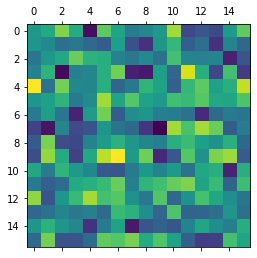

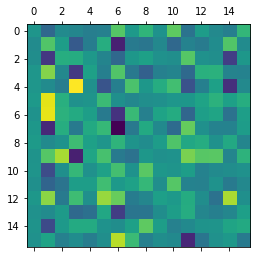

In [844]:
us = reconstruction_model.get_layer(index=1)(x.reshape((1, 2, 2500, 2)), training=False)[0]
# us = reconstruction_model.get_layer(index=1)(x.reshape((1, 2, 28*28, 2)), training=False)[0]
us = tf.cast(us, tf.float32)
one_us = us[0]
usd = one_us[0] - one_us[1]
one_us = one_us[0]
print('shape', one_us.shape)
print('min', tf.reduce_min(one_us).numpy())
print('max', tf.reduce_max(one_us).numpy())
print('norm', tf.norm(one_us).numpy())
print('max of diff', tf.reduce_max(tf.abs(usd)).numpy())
print('norm of diff', tf.norm(usd).numpy())
plt.matshow(one_us.numpy().T)
plt.matshow(usd.numpy().T)

norm of diff 4.4509697
(1, 2, 16, 16)
[ 0.35972115  0.1347226   0.01379196  0.07662514  0.03503884 -0.22209014
  0.04756711  0.40138662 -0.20620035 -0.29124877 -0.15089206 -0.02192007
  0.20096913 -0.06490839 -0.06307247  0.05250341]
(1, 2, 2500, 2)


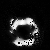

In [889]:
# us1 = reconstruction_model.get_layer(index=1)(tf.reshape(X[0], (1, 2, 28*28, 2)), training=False)[0]
# us2 = reconstruction_model.get_layer(index=1)(tf.reshape(X[1], (1, 2, 28*28, 2)), training=False)[0]
us1 = reconstruction_model.get_layer(index=1)(tf.reshape(X[1], (1, 2, 2500, 2)), training=False)[0]
us2 = reconstruction_model.get_layer(index=1)(tf.reshape(X[5], (1, 2, 2500, 2)), training=False)[0]
us1 = tf.cast(us1, tf.float32)
us2 = tf.cast(us2, tf.float32)
print('norm of diff', tf.norm(us2-us1).numpy())
us_mod = (us1 + 0.5 * (us2 - us1)).numpy()
print(us_mod.shape)
print(us_mod[0][0][0])
#us_mod[0][0][1] = np.zeros((16))
#us_mod[0][0][0][15] = 0.2
r = l1.reconstruct(tf.cast(us_mod, tf.float32))
print(r.shape)
r_one = r[0][0]
r_img = vecs_to_img(tf.squeeze(r_one).numpy())
tf.keras.utils.array_to_img(r_img, scale=False)

-0.6036593
0.7033222


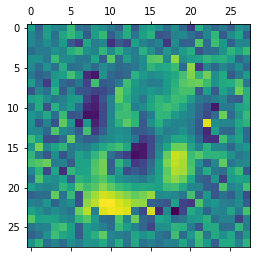

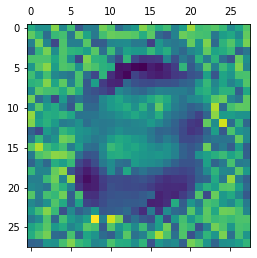

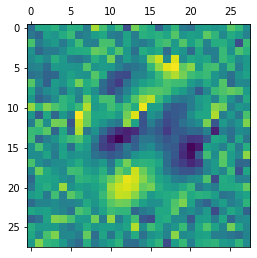

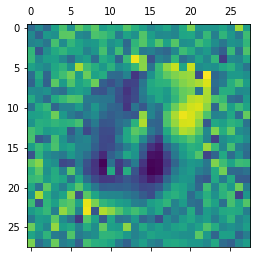

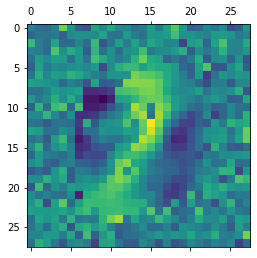

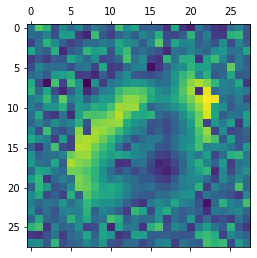

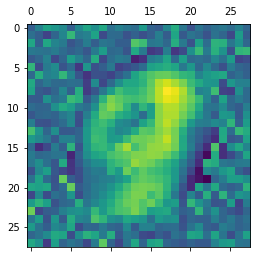

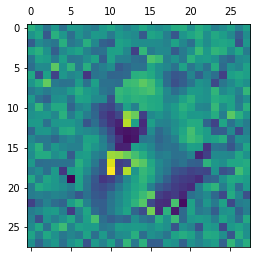

In [980]:
le = l1.columns[0].context_aggregator.downstream_positions.numpy()
#le = le.reshape((50,50,-1))
le = le.reshape((28,28,-1))
print(tf.reduce_min(le[:, :, 0]).numpy())
print(tf.reduce_max(le[:, :, 0]).numpy())
for d in range(0, le.shape[2]):
    plt.matshow(le[:, :, d])

# Layer 2

In [999]:
X_2 = upstream_state_model.predict(X, batch_size=64)
Y_2 = X_2

In [1161]:
inp_2 = Input(shape=(2, 16, 16))
l2 = PtolemyLayer(
    num_channels=1,
    num_instances_per_channel=1,
    context_fan_in=16,
    upstream_dim=10, # TODO! Was 32
    position_dim=4,
    stride=1,
    permanence_loss_rho=0.1, # TODO! Was 0.01,
    initial_sharpness=1.0,
    noise_rate=0.1,
    train_context=True,
    bypass_rate=0.75,
)

# inp_2 = Input(shape=(2, 16, 16))
# l2 = PtolemyLayer(
#     num_channels=1,
#     num_instances_per_channel=1,
#     context_fan_in=16,
#     upstream_dim=32,
#     position_dim=4,
#     stride=1,
#     permanence_loss_rho=0.01,
#     initial_sharpness=1.0,
#     noise_rate=0.1,
#     train_context=True,
#     bypass_rate=0.75,
# )


upstream_state_2, downstream_reconstruction_2 = l2(inp_2)

reconstruction_model_2 = tf.keras.models.Model(inputs=[inp_2], outputs=downstream_reconstruction_2)
upstream_state_model_2 = tf.keras.models.Model(inputs=[inp_2], outputs=upstream_state_2)

optimizer_2 = tf.keras.optimizers.Adam(
    learning_rate = 0.002,
)
optimizer_2 = tf.keras.mixed_precision.LossScaleOptimizer(optimizer_2)
reconstruction_model_2.compile(
    loss = zero_loss, #'mean_squared_error',
    optimizer = optimizer_2,
    metrics = ['cosine_similarity'],
)
reconstruction_model_2.summary()

Model: "model_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(None, 2, 16, 16)]       0         
_________________________________________________________________
ptolemy_layer_78 (PtolemyLay [(None, 2, 1, 10), (None, 822203    
Total params: 822,203
Trainable params: 821,946
Non-trainable params: 257
_________________________________________________________________


In [1162]:
log_dir = "ptolemynet_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
l2.is_bootstrapping.assign(True)

#tf.keras.backend.set_value(reconstruction_model_2.optimizer.learning_rate, 0.001)

tf.config.experimental.reset_memory_stats('GPU:0')
history = reconstruction_model_2.fit([X_2], Y_2, epochs=32, batch_size=128) #, callbacks=[tensorboard_callback])
tf.config.experimental.get_memory_info('GPU:0')

Epoch 1/32
235/235 [==============================] - 18s 49ms/step - loss: 1.0752 - cosine_similarity: 0.6559 - permanence_loss: 1.3953 - full_reconstruction_error: 0.6397 - reconstruction_error: 0.3437 - mean_l1_activity: 0.8352 - position_reconstruction_error: 0.0180 - upstream_scale_loss: 0.6976 - reconstruction_scale_loss: 3.6065e-06
Epoch 2/32
235/235 [==============================] - 10s 44ms/step - loss: 0.7984 - cosine_similarity: 0.8009 - permanence_loss: 1.5138 - full_reconstruction_error: 0.5389 - reconstruction_error: 0.1991 - mean_l1_activity: 0.3301 - position_reconstruction_error: 0.0087 - upstream_scale_loss: 0.8652 - reconstruction_scale_loss: 6.2968e-09
Epoch 3/32
235/235 [==============================] - 10s 44ms/step - loss: 0.4789 - cosine_similarity: 0.8256 - permanence_loss: 1.4582 - full_reconstruction_error: 0.2567 - reconstruction_error: 0.1744 - mean_l1_activity: 0.4400 - position_reconstruction_error: 0.0056 - upstream_scale_loss: 0.8173 - reconstruction_

{'current': 172362752, 'peak': 726628352}

In [1163]:
l2.is_bootstrapping.assign(False)
tf.keras.backend.set_value(reconstruction_model_2.optimizer.learning_rate, 0.001)
history = reconstruction_model_2.fit([X_2], Y_2, epochs=32, batch_size=128)

Epoch 1/32
235/235 [==============================] - 10s 45ms/step - loss: 0.1887 - cosine_similarity: 0.9373 - permanence_loss: 1.0730 - full_reconstruction_error: 0.1685 - reconstruction_error: 0.0627 - mean_l1_activity: 0.0939 - position_reconstruction_error: 0.0569 - upstream_scale_loss: 0.9609 - reconstruction_scale_loss: 0.0134
Epoch 2/32
235/235 [==============================] - 11s 45ms/step - loss: 0.1837 - cosine_similarity: 0.9345 - permanence_loss: 0.9991 - full_reconstruction_error: 0.5220 - reconstruction_error: 0.0655 - mean_l1_activity: 0.0833 - position_reconstruction_error: 0.2571 - upstream_scale_loss: 0.9639 - reconstruction_scale_loss: 0.0144
Epoch 3/32
235/235 [==============================] - 10s 45ms/step - loss: 0.1804 - cosine_similarity: 0.9328 - permanence_loss: 0.9507 - full_reconstruction_error: 0.6497 - reconstruction_error: 0.0672 - mean_l1_activity: 0.0806 - position_reconstruction_error: 0.4824 - upstream_scale_loss: 0.9634 - reconstruction_scale_lo

In [ ]:
%tensorboard --logdir ptolemynet_logs/fit

In [1164]:
x_2 = X_2[1]
x_2_img = vecs_to_img(l1.reconstruct(tf.cast(x_2, tf.float32))[0].numpy())
tf.keras.utils.array_to_img(x_2_img, scale=False)

In [1165]:
y_2 = reconstruction_model_2.predict(tf.reshape(x_2, (1, 2, 16, 16)))[0]
y_2_img = vecs_to_img(l1.reconstruct(tf.cast(y_2, tf.float32))[0].numpy())
tf.keras.utils.array_to_img(y_2_img, scale=False)

4.0
4.0


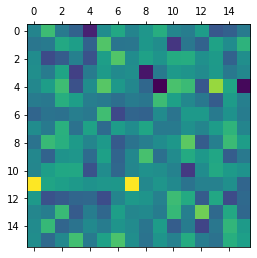

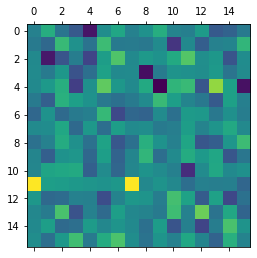

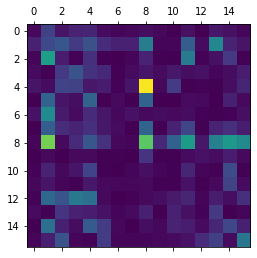

In [1166]:
plt.matshow(tf.cast(x_2[0], tf.float32).numpy().T)
plt.matshow(tf.cast(y_2[0], tf.float32).numpy().T)
print(tf.norm(x_2[0]).numpy())
print(tf.norm(y_2[0]).numpy())
rd = tf.cast(x_2[0], tf.float32).numpy() - tf.cast(y_2[0], tf.float32).numpy()
plt.matshow(np.abs(rd.T), vmin=0.0, vmax=0.5)

shape (1, 10)
min -0.22455914
max 0.7840623
norm 1.0
max of diff 1.3489616
norm of diff 1.4127182


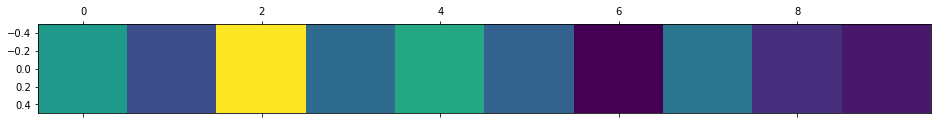

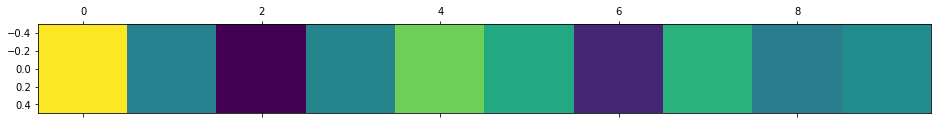

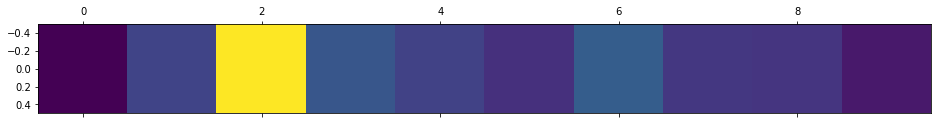

In [1167]:
us = reconstruction_model_2.get_layer(index=1)(x_2.reshape((1, 2, 16, 16)), training=False)[0]
us = tf.cast(us, tf.float32)
one_us = us[0]
usd = one_us[0] - one_us[1]
print('shape', one_us[0].shape)
print('min', tf.reduce_min(one_us[0]).numpy())
print('max', tf.reduce_max(one_us[0]).numpy())
print('norm', tf.norm(one_us[0]).numpy())
print('max of diff', tf.reduce_max(tf.abs(usd)).numpy())
print('norm of diff', tf.norm(usd).numpy())
plt.matshow(one_us[0].numpy())
plt.matshow(one_us[1].numpy())
plt.matshow(usd.numpy())

In [1216]:
us_mod = us.numpy()
print(us_mod.shape)
#us_mod[0][0][0] = np.zeros((10))

# Thickness
#us_mod[0][0][0][1] = -0.1
#us_mod[0][0][0][1] = 0.8

us_mod[0][0][0][4] = -0.2
us_mod[0][0][0][7] = -0.2

#us_mod[0][0] = us_mod[0][0] + 1.5 * (us_mod[0][1] - us_mod[0][0])
r = l2.reconstruct(us_mod)
r = l1.reconstruct(r)
y_2_mod_img = vecs_to_img(r[0][0].numpy())
tf.keras.utils.array_to_img(y_2_mod_img, scale=False)

(1, 2, 1, 10)


# Toy application: Mnist classifier

In [248]:
Y_train_sorted = np.take_along_axis(Y_train, sorted_indexes, axis=0)

In [1149]:
#embeddings = upstream_state_model.predict(X, batch_size=32)
embeddings = upstream_state_model_2.predict(X_2, batch_size=32)

In [1150]:
flattened_embeddings = embeddings.reshape((60000, -1))

In [1159]:
p = np.random.permutation(len(flattened_embeddings))
X_classifier = flattened_embeddings[p]
Y_classifier = tf.keras.utils.to_categorical(Y_train_sorted, 10)[p]


model = tf.keras.Sequential(
    [
        #Input(shape=(256)),
        Input(shape=(10)),
        #BatchNormalization(),
        #Dropout(0.25),
        #Dense(256, activation="relu"),
        #Dropout(0.25),
        Dense(128, activation="relu"),
        #Dropout(0.25),
        Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dense_11 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 2,738
Trainable params: 2,718
Non-trainable params: 20
_________________________________________________________________


In [1160]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
model.fit(X_classifier, Y_classifier, batch_size=64, epochs=32, validation_split=0.1)

Epoch 1/32
844/844 [==============================] - 2s 2ms/step - loss: 0.4373 - accuracy: 0.8911 - val_loss: 0.1835 - val_accuracy: 0.9470
Epoch 2/32
844/844 [==============================] - 2s 2ms/step - loss: 0.1992 - accuracy: 0.9431 - val_loss: 0.1370 - val_accuracy: 0.9613
Epoch 3/32
844/844 [==============================] - 2s 2ms/step - loss: 0.1669 - accuracy: 0.9511 - val_loss: 0.1199 - val_accuracy: 0.9642
Epoch 4/32
844/844 [==============================] - 2s 2ms/step - loss: 0.1532 - accuracy: 0.9547 - val_loss: 0.1122 - val_accuracy: 0.9660
Epoch 5/32
844/844 [==============================] - 2s 2ms/step - loss: 0.1481 - accuracy: 0.9563 - val_loss: 0.1084 - val_accuracy: 0.9670
Epoch 6/32
844/844 [==============================] - 2s 2ms/step - loss: 0.1428 - accuracy: 0.9572 - val_loss: 0.1021 - val_accuracy: 0.9690
Epoch 7/32
844/844 [==============================] - 2s 2ms/step - loss: 0.1384 - accuracy: 0.9587 - val_loss: 0.1009 - val_accuracy: 0.9675
Epoch 

## Exports and animations

In [ ]:
tf.keras.utils.plot_model(reconstruction_model, expand_nested=True)

In [950]:
def animate_interpolation(x1, x2, reconstruction_fun, filename, min_coeff=0.0, max_coeff=1.0, steps=20):
    fig = plt.figure()
    animate = lambda i: reconstruction_fun(x1 + (min_coeff + float(i) / steps * (max_coeff - min_coeff)) * (x2 - x1))
    anim = animation.FuncAnimation(fig, animate, frames=steps, interval=100, blit=True)
    anim.save(filename, fps=15, writer='imagemagick')
    plt.close(fig)

In [951]:
def reconstruct_l1(x):
    recon = l1.reconstruct(x)[0][0]
    recon_im_array = vecs_to_img(tf.squeeze(recon).numpy())
    recon_im = tf.keras.utils.array_to_img(recon_im_array, scale=False)
    return plt.imshow(recon_im, cmap='gray', vmin=0, vmax=255),

def reconstruct_l2(x):
    recon = l2.reconstruct(x)
    recon = l1.reconstruct(recon)[0][0]
    recon_im_array = vecs_to_img(tf.squeeze(recon).numpy())
    recon_im = tf.keras.utils.array_to_img(recon_im_array, scale=False)
    return plt.imshow(recon_im, cmap='gray', vmin=0, vmax=255),

In [759]:
#us1 = reconstruction_model.get_layer(index=1)(tf.reshape(X[0], (1, 2, 28*28, 2)), training=False)[0]
#us2 = reconstruction_model.get_layer(index=1)(tf.reshape(X[1], (1, 2, 28*28, 2)), training=False)[0]
us1 = reconstruction_model.get_layer(index=1)(tf.reshape(X[1], (1, 2, 2500, 2)), training=False)[0]
us2 = reconstruction_model.get_layer(index=1)(tf.reshape(X[5], (1, 2, 2500, 2)), training=False)[0]

animate_interpolation(us1, us2, reconstruct_l1, 'test.gif', min_coeff=0.0, max_coeff=1.0, steps=40)

In [968]:
us1_mod1 = us.numpy()
us1_mod2 = us.numpy()
# Parameter 29: Thickness
#us1_mod1[0][0][0][29] = -20.0
#us1_mod2[0][0][0][29] = 7.0
# Parameter 9: Bottom/top heavy
#us1_mod1[0][0][0][9] = -2.0
#us1_mod2[0][0][0][9] = 2.0
# Parameter 21: tilt
#us1_mod1[0][0][0][21] = -0.5
#us1_mod2[0][0][0][21] = 2.0
# Parameter 23: "negative threenes"
#us1_mod1[0][0][0][2] = -0.5
#us1_mod2[0][0][0][2] = 0.5
us1_mod2[0][0] = us1_mod2[0][1]

animate_interpolation(us1_mod1, us1_mod2, reconstruct_l2, 'level_2_boxes_rotation_blend.gif', min_coeff=-1.0, max_coeff=2.0, steps=40)